In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from  scipy.stats import rankdata

In [17]:
df = pd.read_csv("/home/bruce1996/nvme2/metaphlan3/metaphlan_comparison_without_duplicated.txt",sep='\t',index_col=0)
species_idx = [bool(re.search('s__',x)) and bool(re.search('t__',x)) == False for x in df.index]
species_m = df.loc[species_idx,:]
species_m.index = [x.split('|')[-1] for x in species_m.index]
samples = list(set([x.split('_')[0] for x in species_m.columns]))
#count number of species in v2/v3
n_species_dict = dict()
for s in samples :
    idx_v2 = species_m.index[species_m.loc[:,s+'_metaphlan2'].values > 0]
    idx_v3 = species_m.index[species_m.loc[:,s+'_metaphlan3'].values > 0]
    idx_union = set(list(idx_v2)+list(idx_v3))
    n_species_dict[s] = (len(idx_v2),len(idx_v3),len(idx_union))

In [10]:
v2_matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/latest_format_metaphlan_table.txt",sep='\t',index_col=0)
v2_matrix['Genus'] = [x.split("_")[2] for x in v2_matrix.index]
v3_matrix = pd.read_csv("/home/bruce1996/data/MCI/metaphlan_result/metaphlan_format_table.txt",sep='\t',index_col=0)
v3_matrix['Genus'] = [x.split("_")[2] for x in v3_matrix.index]
samples = list(set(v2_matrix.columns).intersection(v3_matrix.columns))
v2_genus = v2_matrix.groupby("Genus").agg('sum')
v3_genus = v3_matrix.groupby("Genus").agg('sum')

In [ ]:
comparison_m = pd.DataFrame()
for s in samples :
    v2 = v2_genus.loc[:,s]
    v3 = v3_genus.loc[:,s]
    df = pd.concat([v2,v3],axis=1).fillna(0)
    df.columns = ['v2','v3']
    df['sample'] = [s] * df.shape[0]
    df['species'] = list(df.index)
    comparison_m = pd.concat([comparison_m,df])

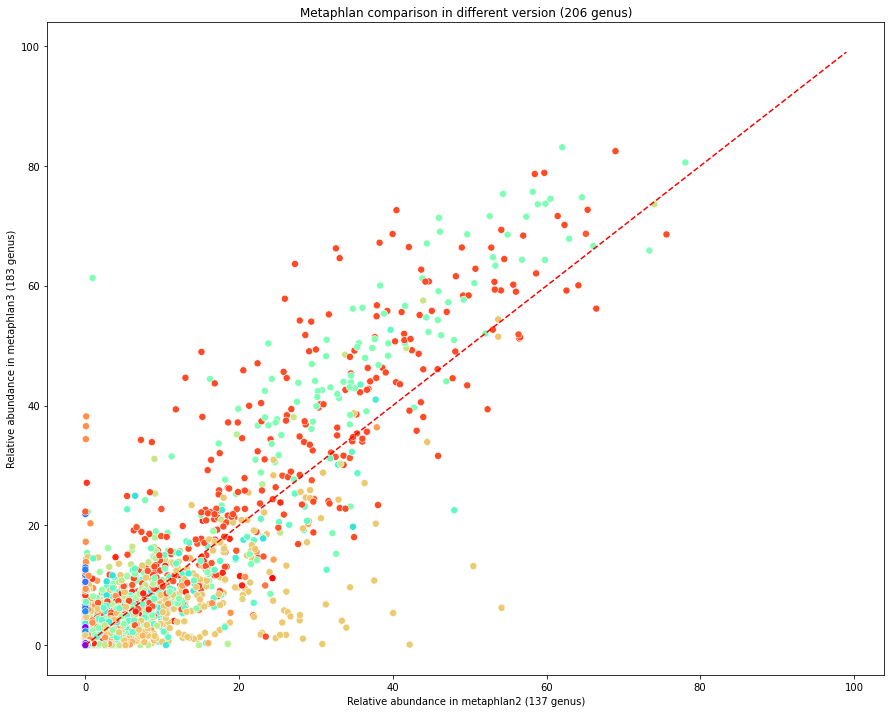

In [28]:
plt.figure(figsize=(15,12))
ax = sns.scatterplot(data=comparison_m,x='v2',y='v3',hue='species',palette='rainbow_r',s=50)
plt.plot(np.arange(0,100),color='r',linestyle='--')
ax.legend().set_visible(False)
plt.xlabel("Relative abundance in metaphlan2 (%d genus)" % v2_genus.shape[0])
plt.ylabel("Relative abundance in metaphlan3 (%d genus)" % v3_genus.shape[0])
plt.title("Metaphlan comparison in different version (%d genus)" % len(set(v2_genus.index).union(v3_genus.index)))
plt.savefig("/home/bruce1996/nvme2/metaphlan3/metaphlan_comparison/metaphlan_comparison_genus_level_scatterplot.png",dpi=300,bbox_inches='tight')

In [3]:
ranking_df = pd.DataFrame()
for sample in samples :
    plot_df = pd.DataFrame({'x':rankdata([-1 * i for i in species_m.loc[:,'%s_metaphlan2' % sample]]).astype(int),
                        'y':rankdata([-1 * i for i in species_m.loc[:,'%s_metaphlan3' % sample]]).astype(int),
                        'Sample' : [sample] * species_m.shape[0],
                        'Species' : list(species_m.index)})
    ranking_df = pd.concat([ranking_df,plot_df])
ranking_df['Gap'] = [abs(ranking_df['x'].values[idx] - ranking_df['y'].values[idx]) for idx in range(ranking_df.shape[0])]

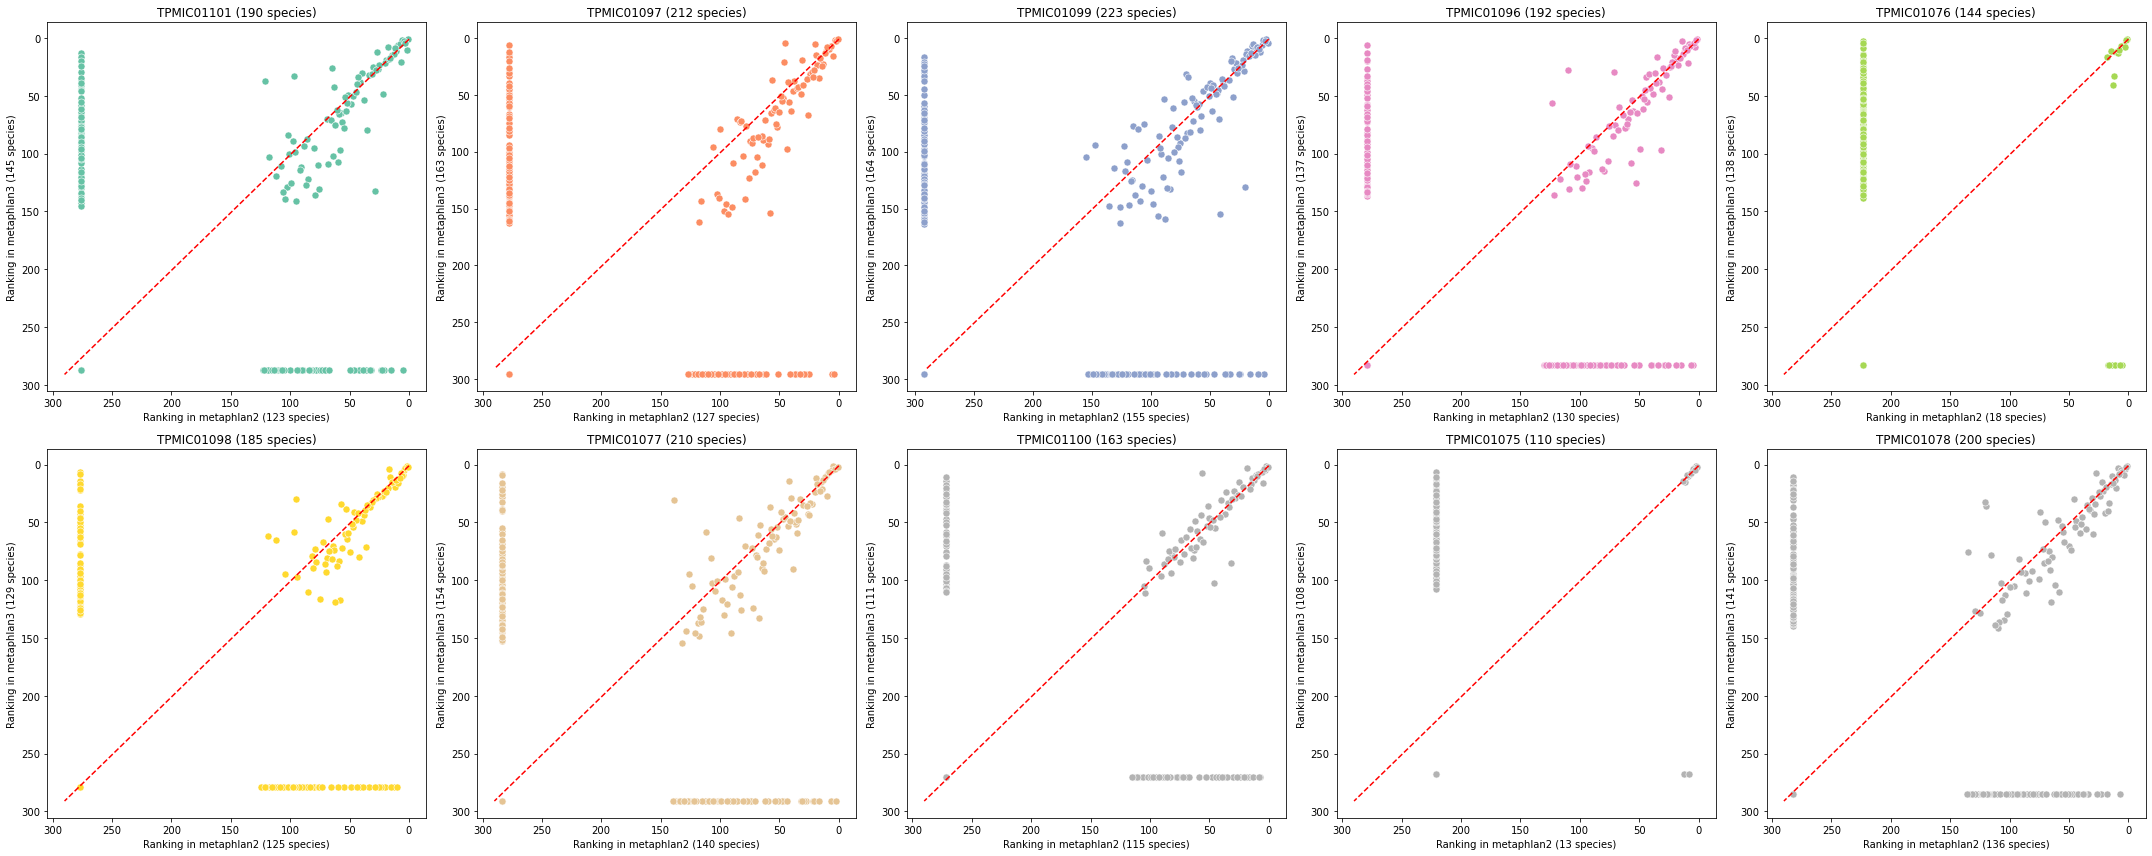

In [120]:
fig, ax = plt.subplots(2,5,figsize=(30,12))
cmap = plt.get_cmap('Set2')

for idx,axs in enumerate(ax.ravel()) :
    plot_df = ranking_df[np.where(ranking_df['Sample'] == samples[idx],True,False)]
    sns.scatterplot(data=plot_df,x='x',y='y',color=mpl.colors.rgb2hex(cmap(idx)),s=50,ax=axs)
    axs.plot(np.arange(1,max(ranking_df['x'])),color='r',linestyle='--')
    axs.set_title("%s (%d species)" % (samples[idx],n_species_dict[samples[idx]][2]))
    axs.set_xlabel("Ranking in metaphlan2 (%d species)" % n_species_dict[samples[idx]][0])
    axs.set_ylabel("Ranking in metaphlan3 (%d species)" % n_species_dict[samples[idx]][1])
    axs.invert_xaxis()
    axs.invert_yaxis()
    #plt.legend(bbox_to_anchor=(1.05,1))
    plt.tight_layout()
plt.savefig("/home/bruce1996/nvme2/metaphlan3/metaphlan_comparison/metaphlan_comparison_sub_qqplot.png",dpi=300,bbox_inches='tight')

# Explode the different species

In [4]:
diff_df = ranking_df[ranking_df['Gap'] > 100]

In [5]:
diff_s = set(diff_df['Species'])
diff_specie_dict = dict()
anomaly_l = []
for s in diff_s : 
    n_sample = sum(diff_df['Species'] == s)
    diff_specie_dict[s] = n_sample
    if n_sample > 5 :
        anomaly_l.append(s)

In [6]:
anomaly_df = pd.DataFrame()
for sample in samples :
    plot_df = pd.DataFrame({'x':species_m.loc[anomaly_l,'%s_metaphlan2' % sample],
                        'y':species_m.loc[anomaly_l,'%s_metaphlan3' % sample],
                        'Sample' : [sample] * len(anomaly_l),
                        'Species' : anomaly_l})
    anomaly_df = pd.concat([anomaly_df,plot_df])

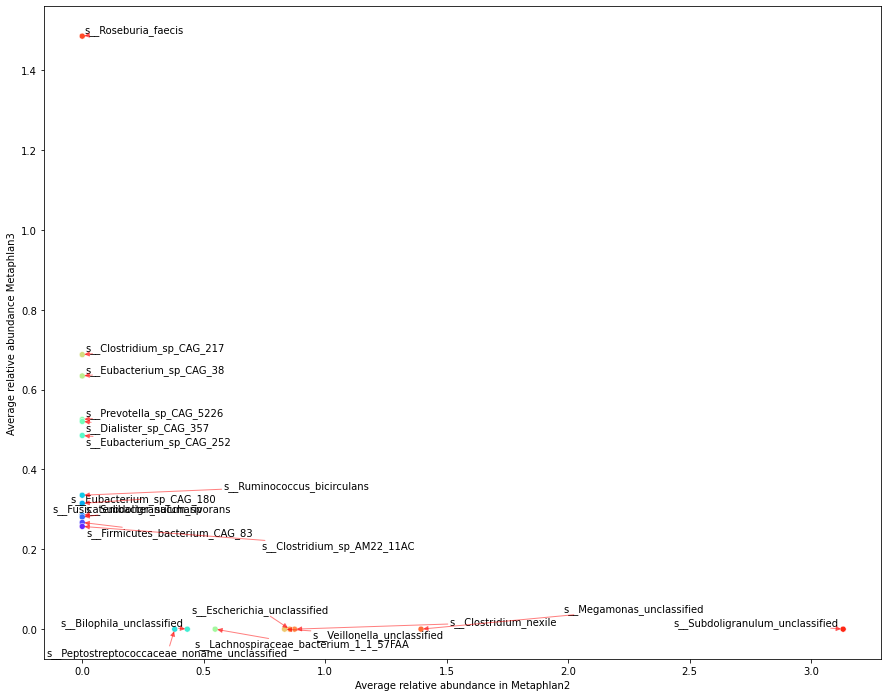

In [15]:
from adjustText import adjust_text
df = anomaly_df.groupby('Species').agg('sum')
df['Sum'] = df['x'] + df['y']
df = df.sort_values(by='Sum',ascending=False)
plt.figure(figsize=(15,12))
df['x'] = df['x'] / 10
df['y'] = df['y'] / 10
ax = sns.scatterplot(data=df.iloc[:20,:],x='x',y='y',hue='Species',palette='rainbow_r')
ax.legend([],[], frameon=False)

plt.xlabel("Average relative abundance in Metaphlan2")
plt.ylabel("Average relative abundance Metaphlan3")
texts = []
for x, y, text in zip(df.iloc[:20, 0], df.iloc[:20, 1], df.index[:20]):
    texts.append(ax.text(x, y, text))
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>",
                                                    color='r', alpha=0.5))
plt.savefig("/home/bruce1996/nvme2/metaphlan3/metaphlan_comparison/metaphlan_comparison_top20_anomaly.png",dpi=300,bbox_inches='tight')